# Анализ бизнес-показателей

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:  
•	лог сервера с данными о посещениях сайта Яндекс.Афиши,  
•	выгрузка всех заказов за этот период,  
•	статистика рекламных расходов.
Необходимо оптимизировать маркетинговые затраты на продвижение продукта.

***Описание данных***  
В нашем распоряжении три датасета.  
Файл visits_log.csv хранит лог сервера с информацией о посещениях сайта,  
orders_log.csv — информацию о заказах,  
costs.csv — информацию о расходах на маркетинг.

Структура visits_log.csv:  
•	Uid — уникальный идентификатор пользователя,  
•	Device — категория устройства пользователя,  
•	Start Ts — дата и время начала сессии,  
•	End Ts — дата и время окончания сессии,  
•	Source Id — идентификатор источника перехода на сайт.

Структура orders_log.csv:  
•	Uid — уникальный идентификатор пользователя,  
•	Buy Ts — дата и время заказа,  
•	Revenue — сумма заказа.

Структура costs.csv:  
•	source_id — идентификатор рекламного источника,  
•	dt — дата проведения рекламной кампании,  
•	costs — расходы на эту кампанию.

***Цель проекта***

Изучить:<br/>
      •	 как клиенты пользуются сервисом,<br/>
      •	  когда делают первые покупки на сайте,<br/>
      •	  сколько денег приносит компании каждый клиент,<br/>
      •	  когда расходы на привлечение клиента окупаются.<br/>
Посчитать метрики трёх видов:<br/>
      •	  продуктовые,<br/>
      •	  метрики электронной коммерции,<br/>
      •	 маркетинговые.<br/>
Отобразить на графиках изменения каждой метрики во времени.<br/>
Определить источники трафика, на которые маркетологам стоит делать упор.<br/> 
Описать выводы, которые были сделаны после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции.<br/>
Подвести итоги когортного анализа. Определить самые перспективные для компании когорты клиентов.<br/>




<a id="1"></a>
## Открытие файлов с данными

In [1]:
#Библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats as st
import seaborn as sns

In [2]:
# загрузим файл
visits= pd.read_csv('/datasets/visits_log.csv')

In [3]:
# загрузим файл
orders= pd.read_csv('/datasets/orders_log.csv')

In [4]:
# загрузим файл
costs= pd.read_csv('/datasets/costs.csv')

<a id="2"></a>
### Изучение и проверка типов данных

In [5]:
# создадим функцию для автоматизации 
def general_info(table):
    table.columns=table.columns.str.lower()
    table.columns=table.columns.str.replace(' ', '_')
    display('Первые 5 строк таблицы', table.head())
    print(),
    print('Общая информация'),
    print(table.info()),
    print(),
    display('Числовое описание данных', table.describe()),
    print(),
    print('Кол-во дубликатов', table.duplicated().sum())

In [6]:
# Изучим таблицу visits
general_info(visits)

'Первые 5 строк таблицы'

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168



Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null object
source_id    359400 non-null int64
start_ts     359400 non-null object
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None



'Числовое описание данных'

,source_id,uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19



Кол-во дубликатов 0


In [7]:
general_info(orders)

'Первые 5 строк таблицы'

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450



Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None



'Числовое описание данных'

,revenue,uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19



Кол-во дубликатов 0


In [8]:
general_info(costs)

'Первые 5 строк таблицы'

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08



Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None



'Числовое описание данных'

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000



Кол-во дубликатов 0


#### Вывод:  

Данные в 3-х таблицах: пропусков нет, дубликатов нет, есть выбросы по минимальным и максимальным значениям. Необходимо только столбцы со временем привести к типу "datetime".

### Подготовка данных

In [9]:
#создадим функцию для автоматизации приведения к нужному типу нужных временных столбцов из разных файлов
def convert_to_datetime(table, columns):
    for row in columns:
        table[row] = pd.to_datetime(table[row], format = '%Y-%m-%d %H:%M:%S')

In [10]:
# Приводим временные столбцы к типу "datetime"
convert_to_datetime(visits, ['end_ts', 'start_ts'])
convert_to_datetime(orders, ['buy_ts'])
convert_to_datetime(costs, ['dt'])


In [11]:
#проверка
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


#### Вывод:  
Все "временные" столбцы привели к типу "datetime".

<a id="2"></a>
## Рассчет метрики и построение графиков

### Продуктовые метрики

#### Рассчет DAU, WAU и MAU. Вычисление средних значений этих метрик за весь период. Отображение изменений метрик во времени на графиках;

На активных пользователей смотрят в трёх измерениях:  
•	DAU (от англ. daily active users) — количество уникальных пользователей в день;  
•	WAU (от англ. weekly active users) — количество уникальных пользователей в неделю;  
•	MAU (от англ. monthly active users) — количество уникальных пользователей в месяц.  
Чтобы посчитать суточное, недельное и месячное использование, выделим в отдельные столбцы год, месяц и неделю, а так же полную дату

In [12]:
visits['start_year'] = visits['start_ts'].dt.year
visits['start_month'] = visits['start_ts'].dt.month
visits['start_week'] = visits['start_ts'].dt.week
visits['start_date'] = visits['start_ts'].dt.date


In [13]:
visits.head()

,device,end_ts,source_id,start_ts,uid,start_year,start_month,start_week,start_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


Посчитаем метрики. Сгруппируем данные по уникальным пользователям и найдём среднее

In [14]:
dau_total = visits.groupby('start_date').agg({'uid': 'nunique'}).mean()
print('Количество уникальных пользователей в день:', int(dau_total))

Количество уникальных пользователей в день: 907


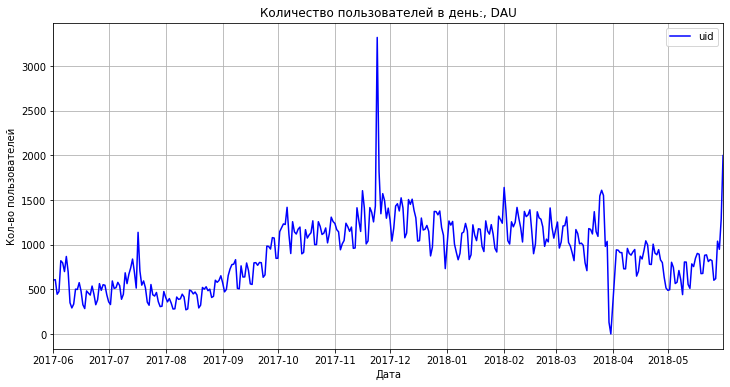

In [15]:
visits.groupby('start_date').agg({'uid':'nunique'}).plot(figsize = (12,6), grid=True, color='blue')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Дата')
plt.title('Количество пользователей в день:, DAU')
plt.show()

In [16]:
wau_total = (
    visits.groupby(['start_week'])
    .agg({'uid': 'nunique'})
    .mean()
)
wau_total
print('Количество уникальных пользователей в неделю:', int(wau_total))

Количество уникальных пользователей в неделю: 5825


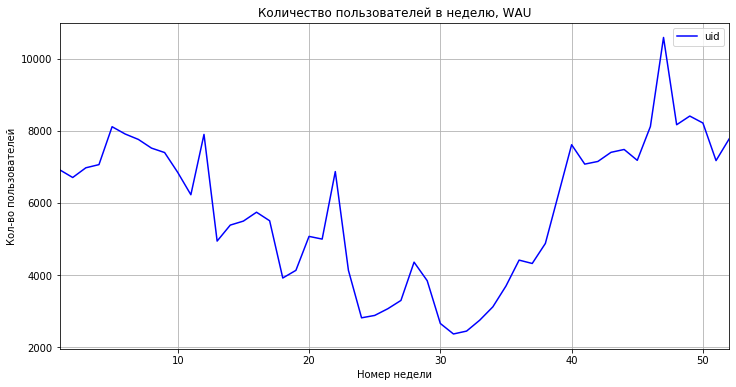

In [17]:
visits.groupby('start_week').agg({'uid':'nunique'}).plot(figsize = (12,6), grid=True, color='blue')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Номер недели')
plt.title('Количество пользователей в неделю, WAU')
plt.show()

In [18]:
mau_total = (
    visits.groupby(['start_year', 'start_month'])
    .agg({'uid': 'nunique'})
    .mean()
)
print('Количество уникальных пользователей в месяц:', int(mau_total))

Количество уникальных пользователей в месяц: 23228


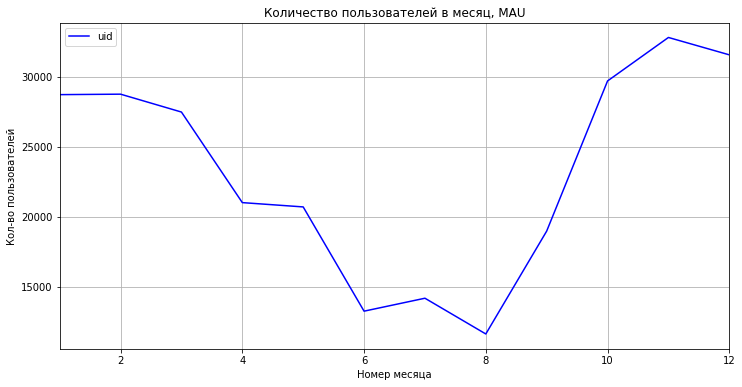

In [19]:
visits.groupby('start_month').agg({'uid':'nunique'}).plot(figsize = (12,6), grid=True, color='blue')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Номер месяца')
plt.title('Количество пользователей в месяц, MAU')
plt.show()

##### Вывод:  
Уникальные пользователи:  
1) ПО ДНЯМ: среднее значение = 907. Постепенное увеличение с лета до нового года. Виден огромный пик - видимо, клиенты покупали подарки на новый год. Затем идет плавное понижение.  
2) ПО НЕДЕЛЯМ: среднее значение = 5825. Тут поведение проще описать : с 5 недели идет понижение и после 30 недели -повышение. Всё зависит от сезона: летом мало праздников, меньше поводов для подарков.  
3) ПО МЕСЯЦАМ: среднее значение = 23228. Еще лучше видно: действительно, летом все заняты  только отдыхом.


#### Cколько раз за день пользователи в среднем заходят на сайт? Построение графика, отражающий изменения метрики во времени;

In [20]:
# сгруппируем по дате и посчитаем кол-во пользователей, итог усредним
count_uid_day = visits.groupby('start_date').agg({'uid': 'count'}).mean()
count_uid_day

uid    987.362637
dtype: float64

In [21]:
visits.head()

,device,end_ts,source_id,start_ts,uid,start_year,start_month,start_week,start_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


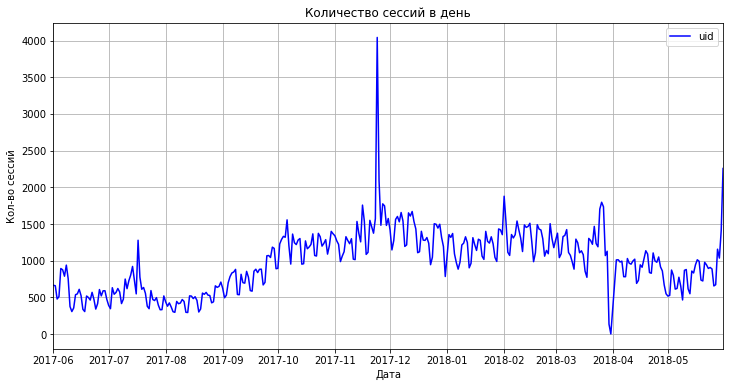

In [22]:
visits.groupby('start_date').agg({'uid': 'count'}).plot(figsize = (12,6), grid=True, color='blue')
plt.ylabel('Кол-во сессий')
plt.xlabel('Дата')
plt.title('Количество сессий в день')
plt.show();

#### Вывод:  
График схож с графиком по кол-ву пользователей в день и причины те же. Кол-во пользователей варьируется примерно от 460 до 1700. Имеются отдельные выбросы.


#### Cколько времени пользователи проводят на сайте? Продолжительность типичной пользовательской сессии за весь период. 

Мы знаем ,сколько пользователей заходит в приложение. Необходимо получить информацию, как долго они там сидят. Ответить на этот вопрос помогает сессия — набор действий пользователя, выполняемый от открытия приложения до окончания его использования.
Полезно изучить то, сколько сессий приходится на одного пользователя, например, за месяц. Это хороший показатель регулярности использования приложения.
Найти эту метрику просто — разделим число сессий на количество пользователей за период:


In [23]:
sessions_per_user = visits.groupby(['start_year', 'start_month']).agg(
    {'uid': ['count', 'nunique']})

sessions_per_user

uid        
                        count nunique
start_year start_month               
2017       6            16505   13259
           7            17828   14183
           8            14355   11631
           9            23907   18975
           10           37903   29692
           11           43969   32797
           12           41983   31557
2018       1            36939   28716
           2            37182   28749
           3            35679   27473
           4            26515   21008
           5            26635   20701

In [24]:
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = (
    sessions_per_user['n_sessions'] / sessions_per_user['n_users']
)
sessions_per_user

n_sessions  n_users  sessions_per_user
start_year start_month                                        
2017       6                 16505    13259           1.244815
           7                 17828    14183           1.256998
           8                 14355    11631           1.234202
           9                 23907    18975           1.259921
           10                37903    29692           1.276539
           11                43969    32797           1.340641
           12                41983    31557           1.330386
2018       1                 36939    28716           1.286356
           2                 37182    28749           1.293332
           3                 35679    27473           1.298693
           4                 26515    21008           1.262138
           5                 26635    20701           1.286653

In [25]:
sessions_per_user.mean()

n_sessions           29950.000000
n_users              23228.416667
sessions_per_user        1.280889
dtype: float64

В месяц один пользователь в среднем проводит в приложении 1, 28 сессии. Не сказать, что продукт используется регулярно.  
Средняя продолжительность сессии или ASL (англ. average session length) показывает, сколько длится сессия пользователя в среднем.

In [26]:
visits['session_duration'] = ((
    visits['end_ts'] - visits['start_ts']
).dt.seconds)/60
print(visits['session_duration'].mean()) 


10.725108143201632


In [27]:
visits['session_duration'].describe()

count    359400.000000
mean         10.725108
std          16.938913
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max        1408.000000
Name: session_duration, dtype: float64

Кажется, всё получилось. Однако взглянем на распределение:

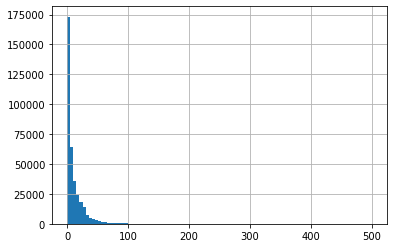

In [28]:
visits['session_duration'].hist(bins=100, range=(0,500)) 

Когда распределение близко к нормальному или нормальное — можно смотреть на среднюю или медиану. Наше — не из таких, рассчитаем моду (значение в выборке, которое встречается чаще всего):

In [29]:
visits['session_duration'].mode()

0    1.0
dtype: float64

##### Вывод: 
 Одна сессия длится в среднем 10 минут, в модном значении- 1 минуту. Это много или мало? Если пользователь успевает за это время сделать заказ, то всё отлично, а если нет — нужно проверить, что ему мешает.


#### Рассчет Retention Rate, применяя когортный анализ. Изменение метрики во времени на графике. Средний Retention Rate на второй месяц «жизни» когорт.

Retention Rate показывает, сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды. Определим событие и период — на их основе сформируем когорту. Возьмём дату, когда пользователь впервые проявил активность в мобильном приложении.
Эти данные запишем в объект Series first_visit. Объединим его с исходным датафреймом visits:


In [30]:
# Сгруппируем данные по столбцу 'uid' методом groupby() и 
# для каждого клиента получим дату его первого заказа — ['start_ts'].min():
first_visit = visits.groupby(['uid'])['start_ts'].min()
first_visit.head()


uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: start_ts, dtype: datetime64[ns]

Получили объект Series, c именем start_ts.
В исходной таблице visits уже есть столбец start_ts. Чтобы в результирующем датафрейме не было двух столбцов с одинаковыми названиями, изменим имя Series на first_start_ts, обратившись к атрибуту name у Series. Причём менять нужно имя Series, а не название переменной, где она сохранена:


In [31]:
first_visit.name = 'first_start_ts'

через join не получилось почему-то((((

visits = visits.join(first_visit, on='uid')  
visits 

In [32]:
#Методом join() объединим датафрейм visits и Series first_visit по столбцу 'uid':
visits = visits.merge(first_visit, on='uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,start_year,start_month,start_week,start_date,session_duration,first_start_ts
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,18.0,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,28.0,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,24.0,2018-03-09 20:05:00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,28.0,2018-03-09 20:05:00


В таблице появился столбец first_start_ts с датами первой покупки клиента.
Следующим шагом выделим из столбцов first_start_ts и start_ts месяцы. Вызовем метод astype(): преобразуем значения столбцов к типу 'datetime64[M]'. [M] в типе datetime64 означает размерность временной метки, в этом случае — месяц:


In [33]:
visits['first_start_month'] = visits['first_start_ts'].astype(
    'datetime64[M]'
)
visits['start_ts_month'] = visits['start_ts'].astype('datetime64[M]')
visits.head(5)


,device,end_ts,source_id,start_ts,uid,start_year,start_month,start_week,start_date,session_duration,first_start_ts,first_start_month,start_ts_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,18.0,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,28.0,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,24.0,2018-03-09 20:05:00,2018-03-01,2018-05-01
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,28.0,2018-03-09 20:05:00,2018-03-01,2018-03-01


Теперь для каждой строки датафрейма можно рассчитать lifetime пользователя в рамках когорты.Обратимся к константе np.timedelta64(1,'M') (где 'M' от англ. month, «месяц»):

In [34]:
visits['cohort_lifetime'] = (
    visits['start_ts_month'] - visits['first_start_month']
)
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')

visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int') 


Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»:

In [35]:
cohorts = visits.groupby(['first_start_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts

,first_start_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждую следующий месяц.
Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц:


In [36]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_start_month', 'uid']
]
print(initial_users_count) 


   first_start_month    uid
0         2017-06-01  13259
12        2017-07-01  13140
23        2017-08-01  10181
33        2017-09-01  16704
42        2017-10-01  25977
50        2017-11-01  27248
57        2017-12-01  25268
63        2018-01-01  22624
68        2018-02-01  22197
72        2018-03-01  20589
75        2018-04-01  15709
77        2018-05-01  15273


Переименуем столбец uid в cohort_users методом rename() (англ. «переименовать»). Параметру columns передадим словарь, где ключ — старое название столбца, а значение — новое:

In [37]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

Объединим данные по когортам с исходным количеством пользователей в когорте:

In [38]:
cohorts = cohorts.merge(initial_users_count,on='first_start_month') 
cohorts

,first_start_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259
...,...,...,...,...
73,2018-03-01,1,861,20589
74,2018-03-01,2,557,20589
75,2018-04-01,0,15709,15709
76,2018-04-01,1,760,15709


Наконец, рассчитаем Retention Rate. Разделим количество активных пользователей в каждом из месяца на исходное число пользователей в когорте:

In [39]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 

Построим сводную таблицу и создадим тепловую карту:

In [40]:
retention_pivot = cohorts.pivot_table(
    index='first_start_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
) 
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_start_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


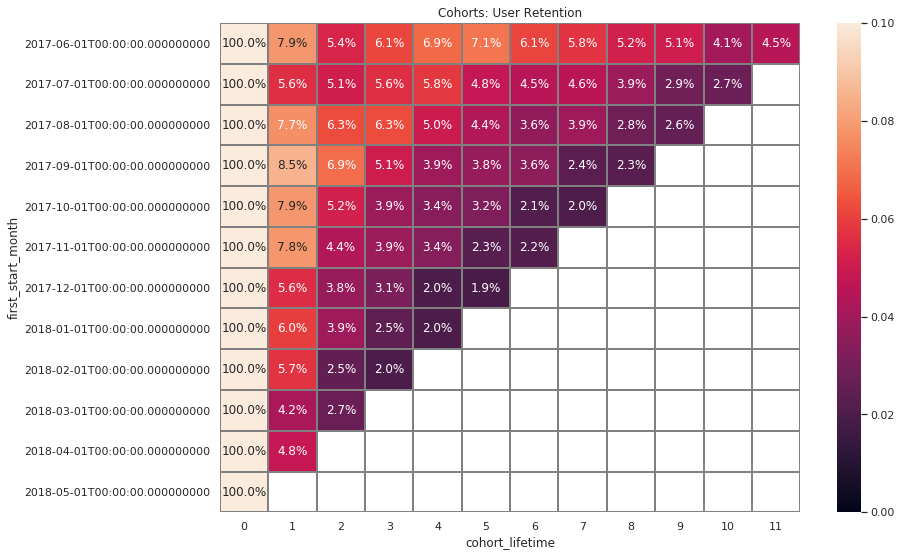

In [41]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin = 0, vmax = 0.1)



##### Вывод:  
Retention Rate в первую неделю убывает по когортам с течением времени. Если для когорты пользователей, пришедших в июне Retention Rate составляет 7,9%, то для пользователей, пришедших в марте - 4,2%. Так, за 9 месяцев коэффициент удержания упал на 3,7%. Но если смотреть по месяцам, то можно увидеть, что показатель был хороший с августа по ноябрь. Возможно, были выбраны неэффективные источники трафика или ухудшилось качество работы службы поддержки.

 ### Метрики электронной коммерции

#### Cколько времени в среднем проходит с момента первого посещения сайта до совершения покупки? 

In [42]:
#найдем, дату первой покупки
first_order = orders.groupby('uid')['buy_ts'].min().reset_index()
first_order

,uid,buy_ts
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00
...,...,...
36518,18445147675727495770,2017-11-24 09:03:00
36519,18445407535914413204,2017-09-22 23:55:00
36520,18445601152732270159,2018-03-26 22:54:00
36521,18446156210226471712,2018-02-18 19:34:00


In [43]:
# переименуем столбец
first_order.columns = ['uid','first_order']
first_order

,uid,first_order
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00
...,...,...
36518,18445147675727495770,2017-11-24 09:03:00
36519,18445407535914413204,2017-09-22 23:55:00
36520,18445601152732270159,2018-03-26 22:54:00
36521,18446156210226471712,2018-02-18 19:34:00


In [44]:
# добавим столбец о первом действии (возвращаемся к таблице visits)
first_order_days = first_order.merge(first_visit, on='uid')
first_order_days

,uid,first_order,first_start_ts
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
...,...,...,...
36518,18445147675727495770,2017-11-24 09:03:00,2017-08-20 13:30:00
36519,18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00
36520,18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00
36521,18446156210226471712,2018-02-18 19:34:00,2017-11-07 10:01:00


In [45]:
# округлим до "дня"
first_order_days['first_order'] = first_order_days['first_order'].astype('datetime64[D]')
first_order_days['first_start_ts'] = first_order_days['first_start_ts'].astype('datetime64[D]')
first_order_days.head(5)

,uid,first_order,first_start_ts
0,313578113262317,2018-01-03,2017-09-18
1,1575281904278712,2017-06-03,2017-06-03
2,2429014661409475,2017-10-11,2017-10-11
3,2464366381792757,2018-01-28,2018-01-27
4,2551852515556206,2017-11-24,2017-11-24


In [46]:
# Найдем теперь разницу между датой первой сессии и датой первой покупки.
first_order_days['time_to_first_order'] = (
    first_order_days['first_order'] - first_order_days['first_start_ts']
                                          ) / np.timedelta64(1,'D')
first_order_days.head(5)

,uid,first_order,first_start_ts,time_to_first_order
0,313578113262317,2018-01-03,2017-09-18,107.0
1,1575281904278712,2017-06-03,2017-06-03,0.0
2,2429014661409475,2017-10-11,2017-10-11,0.0
3,2464366381792757,2018-01-28,2018-01-27,1.0
4,2551852515556206,2017-11-24,2017-11-24,0.0


In [47]:
first_order_days.describe()

,uid,time_to_first_order
count,3.652300e+04,36523.000000
mean,9.213152e+18,16.895901
std,5.324792e+18,47.071200
min,3.135781e+14,0.000000
25%,4.615081e+18,0.000000
50%,9.245161e+18,0.000000
75%,1.383709e+19,2.000000
max,1.844617e+19,363.000000


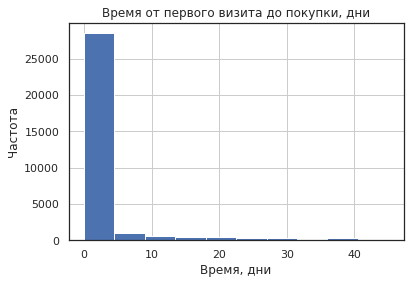

In [48]:
first_order_days['time_to_first_order'].astype('int').hist(bins=10, range=(0,45))
plt.xlabel('Время, дни')
plt.ylabel('Частота')
plt.title('Время от первого визита до покупки, дни')
plt.show();

In [49]:
first_order_days['time_to_first_order'].mode()

0    0.0
dtype: float64

In [50]:
first_order_days['time_to_first_order'].median()

0.0

##### Вывод:
Так как распределение не нормальное, то среднее значение не уместно. Большинство покупок было совершено меньше, чем за день с момента первого посещения.



#### Применяя когортный анализ или другой метод, рассчитаем среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев. Изучать изменение этой метрики во времени необязательно.

In [51]:
# добавим столбец с месяцами покупок, то етсь определим кол-во покупок по месяцам
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')

In [52]:
#сгруппируем по месяцам и посчитаем кол-во уник.покупателей
order_per_user = orders.groupby('buy_month').agg({'uid':['count', 'nunique']})
# переименуем столбцы
order_per_user.columns = ['n_orders', 'n_users']

In [53]:
# разделим кол-во покупок на кол-во покупателей
order_per_user['order_per_user'] = round(order_per_user['n_orders'] / order_per_user['n_users'],2)
order_per_user.head()

,n_orders,n_users,order_per_user
buy_month,,,
2017-06-01,2354,2023,1.16
2017-07-01,2363,1984,1.19
2017-08-01,1807,1472,1.23
2017-09-01,3387,2750,1.23
2017-10-01,5679,4675,1.21


In [54]:
order_per_user.describe()

,n_orders,n_users,order_per_user
count,13.000000,13.000000,13.000000
mean,3878.076923,3155.307692,1.204615
std,1858.113401,1477.043860,0.068388
min,1.000000,1.000000,1.000000
25%,2363.000000,2023.000000,1.190000
50%,4346.000000,3544.000000,1.230000
75%,5326.000000,4258.000000,1.240000
max,6218.000000,4942.000000,1.270000


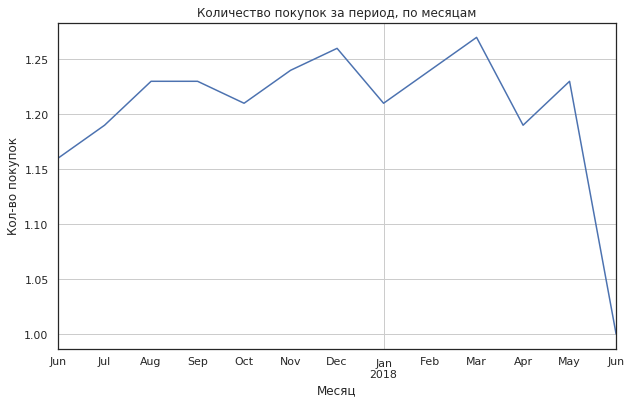

In [55]:
order_per_user['order_per_user'].plot(figsize=(10,6), grid=True)
plt.ylabel('Кол-во покупок')
plt.xlabel('Месяц')
plt.title('Количество покупок за период, по месяцам')
plt.show()

Можно выделить по графику такие особенности поведения пользователей в отношении покупок:  
с августа по май всё было бы гладко, если бы не новый год, праздники -23 февраля и 8 марта (тут наблюдается увеличение покупок). Ну и летом - "тишинаааа"....

Среднее значение кол-ва покупок пользователя за весь период =1,2 покупок.

Теперь с использованием когортного анализа найдем сколько в среднем совершает покупатель покупок за период -6 месяцев.  
Посмотрим разницу с общим средним.

Так как я вставляю этот пункт. Во избежание путаницы в дальнейшем в именах и данных назову по-другому таблицу orders и работаем с ней.

In [56]:
# приведу к основному виду для работы
orders_month= orders[['buy_ts','revenue','uid']]

In [57]:
# наши обычные действия вход:
# выделим первый месяц покупки
first_buy = orders_month.groupby('uid')['buy_ts'].min().reset_index()
# переименуем колонки
first_buy.columns = ['uid', 'first_buy']
# соединим
orders_month = orders_month.merge(first_buy, on='uid')
#orders_month.head()

# выделим месяца в столбцах
orders_month['buy_month'] = orders_month['buy_ts'].astype('datetime64[M]')
orders_month['first_buy_month'] = orders_month['first_buy'].astype('datetime64[M]')
orders_month.head()

,buy_ts,revenue,uid,first_buy,buy_month,first_buy_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


In [58]:
# сгруппируем покупки по первому месяцу и по месяцу покупок
orders_month6 = (orders_month.
                groupby(['first_buy_month','buy_month'])
                .agg({'uid':'count', 'revenue':'sum'})
                .reset_index()
               )
orders_month6.head()

,first_buy_month,buy_month,uid,revenue
0,2017-06-01,2017-06-01,2354,9557.49
1,2017-06-01,2017-07-01,177,981.82
2,2017-06-01,2017-08-01,174,885.34
3,2017-06-01,2017-09-01,226,1931.30
4,2017-06-01,2017-10-01,292,2068.58


In [59]:
# переименуем колонку 'uid'
orders_month6 = orders_month6.rename(columns={'uid':'n_orders'})
orders_month6.head()

,first_buy_month,buy_month,n_orders,revenue
0,2017-06-01,2017-06-01,2354,9557.49
1,2017-06-01,2017-07-01,177,981.82
2,2017-06-01,2017-08-01,174,885.34
3,2017-06-01,2017-09-01,226,1931.30
4,2017-06-01,2017-10-01,292,2068.58


In [60]:
# построим сводную таблицу для демонстрации изменения количества заказов по когортам в месяц:
pivot_orders = (orders_month6
                .pivot_table(index='first_buy_month', columns='buy_month', 
                             values='n_orders', aggfunc='sum')
               )
pivot_orders.fillna('')

buy_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_buy_month,,,,,,,,,,,,,
2017-06-01,2354,177,174,226,292,218,276,174,212,153,96,86,
2017-07-01,,2186,100,120,104,72,82,61,50,58,24,53,
2017-08-01,,,1533,108,100,81,85,62,49,78,46,46,
2017-09-01,,,,2933,219,161,164,67,109,108,56,61,
2017-10-01,,,,,4964,314,162,122,129,103,86,125,
2017-11-01,,,,,,4813,397,182,211,136,59,102,
2017-12-01,,,,,,,5052,270,202,179,86,105,
2018-01-01,,,,,,,,3783,224,159,64,78,
2018-02-01,,,,,,,,,4095,222,83,70,


In [61]:
# найдем время жизни когорты. Из месяца совершения покупки вычтем месяц когорты:
orders_month6['cohort_lifetime'] = orders_month6['buy_month']-orders_month6['first_buy_month']

orders_month6['cohort_lifetime'] = orders_month6['cohort_lifetime']/np.timedelta64(1,'M')

orders_month6['cohort_lifetime'] = orders_month6['cohort_lifetime'].round().astype('int')

orders_month6.head()

,first_buy_month,buy_month,n_orders,revenue,cohort_lifetime
0,2017-06-01,2017-06-01,2354,9557.49,0
1,2017-06-01,2017-07-01,177,981.82,1
2,2017-06-01,2017-08-01,174,885.34,2
3,2017-06-01,2017-09-01,226,1931.30,3
4,2017-06-01,2017-10-01,292,2068.58,4


In [62]:
# найдем количество покупателей в каждой когорте: сгруппируем покупки по первому месяцу
# и найдем количество уникальных пользователй методом nunique()
cohort_size = (orders_month
               .groupby('first_buy_month')['uid']
               .nunique()
               .reset_index()
               )
cohort_size.head()


,first_buy_month,uid
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [63]:
# переименуем колонки
cohort_size.columns = ['first_buy_month', 'n_buyers']
cohort_size.head()

,first_buy_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [64]:
#смержим
orders_month6 = orders_month6.merge(cohort_size, on=('first_buy_month'), how='left')
                    
orders_month6.head()

,first_buy_month,buy_month,n_orders,revenue,cohort_lifetime,n_buyers
0,2017-06-01,2017-06-01,2354,9557.49,0,2023
1,2017-06-01,2017-07-01,177,981.82,1,2023
2,2017-06-01,2017-08-01,174,885.34,2,2023
3,2017-06-01,2017-09-01,226,1931.30,3,2023
4,2017-06-01,2017-10-01,292,2068.58,4,2023


In [65]:
# найдем количество заказов на одного пользователя
orders_month6['orders_per_user'] = orders_month6['n_orders']/orders_month6['n_buyers']
orders_month6.head()

,first_buy_month,buy_month,n_orders,revenue,cohort_lifetime,n_buyers,orders_per_user
0,2017-06-01,2017-06-01,2354,9557.49,0,2023,1.163618
1,2017-06-01,2017-07-01,177,981.82,1,2023,0.087494
2,2017-06-01,2017-08-01,174,885.34,2,2023,0.086011
3,2017-06-01,2017-09-01,226,1931.30,3,2023,0.111715
4,2017-06-01,2017-10-01,292,2068.58,4,2023,0.144340


In [66]:
# сформируем сводную таблицу заказов на одного пользователя по когортам и месяцам жизни
pivot_ordes = (orders_month6
               .pivot_table(index='first_buy_month',
                            columns='cohort_lifetime',
                            values='orders_per_user',
                            aggfunc='mean').cumsum(axis=1).round(2)
              )
pivot_ordes.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.7,1.84,1.92,2.03,2.1,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08-01,1.12,1.2,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.6,,
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.5,,,
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12-01,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02-01,1.12,1.18,1.21,1.22,,,,,,,,


6 месяцев прожили когорты с 2017-06-01 по 2017-12-01.


In [67]:
# сделаем срез по когорте 2017-12-01 и возьмем данные 5 колонок (6 месяцев), усредним
print('Cреднее количество покупок на одного покупателя за за 6 месяцев:', 
      (pivot_ordes.loc[:'2017-12-01',:5][5].mean().round(2)))

Cреднее количество покупок на одного покупателя за за 6 месяцев: 1.44


##### Вывод:

Cреднее количество покупок на одного покупателя за определённый период - 6 месяцев равна 1.44  
Значение больше, чем у общего среднего.

#### Рассчитаем средний чек, применяя группировку по времени совершения покупки. Когортный анализ не подходит — он может исказить расчёты. Построим график, отражающий изменения метрики во времени.

Ещё одна задача когортного анализа: понять, как с течением времени изменяется средний чек — сумма покупок, делённая на число покупателей. Так узнаем, увеличивается или уменьшается средний чек покупателей, которые продолжают делать заказы в интернет-магазине.  


In [68]:
# средний чек на каждый месяц
revenue_cohorts = round(orders.groupby(['buy_month']).agg({'revenue':'mean'}),2)
revenue_cohorts

,revenue
buy_month,
2017-06-01,4.06
2017-07-01,5.31
2017-08-01,4.85
2017-09-01,5.42
2017-10-01,4.93
2017-11-01,4.78
2017-12-01,5.85
2018-01-01,4.11
2018-02-01,4.84


In [69]:
revenue_cohorts.describe()

,revenue
count,13.000000
mean,4.838462
std,0.656555
min,3.420000
25%,4.770000
50%,4.850000
75%,5.310000
max,5.850000


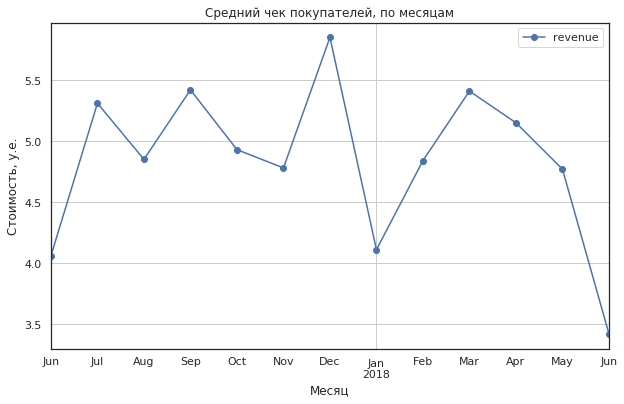

In [70]:
revenue_cohorts.plot(figsize=(10,6), grid=True, style='o-')
plt.ylabel('Стоимость, у.е.')
plt.xlabel('Месяц')
plt.title('Средний чек покупателей, по месяцам')
plt.show()

##### Вывод:

Средний чек самый "сильный" в декабре. Причина - Новый год. Самый "слабый" в январе - деньги закончились же)))  
В феврале кошелек пополнился уже, да и праздники ...

#### Как меняется LTV на покупателя по когортам.  LTV — накопительная метрика. Рассчитаем средний LTV по когортам за 6 месяцев; в расчёт включим когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%. Отразим изменения метрики во времени на графике;

LTV (от англ. lifetime value) — «пожизненная» ценность клиента. Это — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок. При расчёте LTV обычно обращаются к валовой прибыли с клиента за период.
LTV удобно считать по когортам. Что для этого нужно:  
1.	найти дату первой покупки каждого покупателя;      
2.	вычислить число новых покупателей за каждую дату;    
3.	добавить дату первой покупки в таблицу с заказами;  
4.	сгруппировать таблицу и посчитать выручку.  

Данные почти за год. Удобнее всего сформировать месячные когорты. Выделим месяцы из дат в таблицах с заказами и расходами:

In [71]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
costs['month'] = costs['dt'].astype('datetime64[M]') 

Получим месяц первой покупки каждого покупателя:

In [72]:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders.head()


,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


Посчитаем количество новых покупателей (n_buyers) за каждый месяц:

In [73]:
cohort_sizes = (
    first_orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()


,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами:

In [74]:
orders_new = pd.merge(orders,first_orders, on='uid')
orders_new.head()


,buy_ts,revenue,uid,buy_month,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку. Сбросим индекс методом reset_index():

In [75]:
cohorts = (
    orders_new.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
cohorts.head()


,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


Строка таблицы cohorts показывает, какую выручку принесла когорта. Например, строка 0 сообщает, что покупатели, сделавшие свой первый заказ в июне 2017 года, в этом же месяце принесли суммарно 9557.49 у.е. выручки.
С точки зрения когортного анализа LTV — накопительная выручка когорты в пересчёте на количество людей. Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:


In [76]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head()


,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


Ранее в таблице появился столбец с новыми покупателями — n_buyers. В первых 5 строках его значение не изменяется — ведь это продажи одной и той же когорты.
До расчёта LTV осталось 2 шага. Во-первых, LTV считают не из выручки, а из валовой прибыли. Значит, нужно найти валовую прибыль, умножив выручку на маржинальность. Во-вторых, LTV — относительный показатель. Значит его удобнее смотреть по «возрастным» когортам, где в столбцах — не месяц заказа, а возраст (age) когорты.


In [77]:
margin_rate = 1 # по условию

report['gp'] = report['revenue'] * margin_rate
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report


,first_order_month,n_buyers,order_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4
...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1
77,2018-05-01,2988,2018-05-01,13925.76,13925.76,0


Наконец, найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. Для наглядности визуализируем когорты в виде сводной таблицы:

In [78]:
report['ltv'] = report['gp'] / report['n_buyers']

output = report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='sum'
).round(2) 

output.fillna('') 


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.64,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


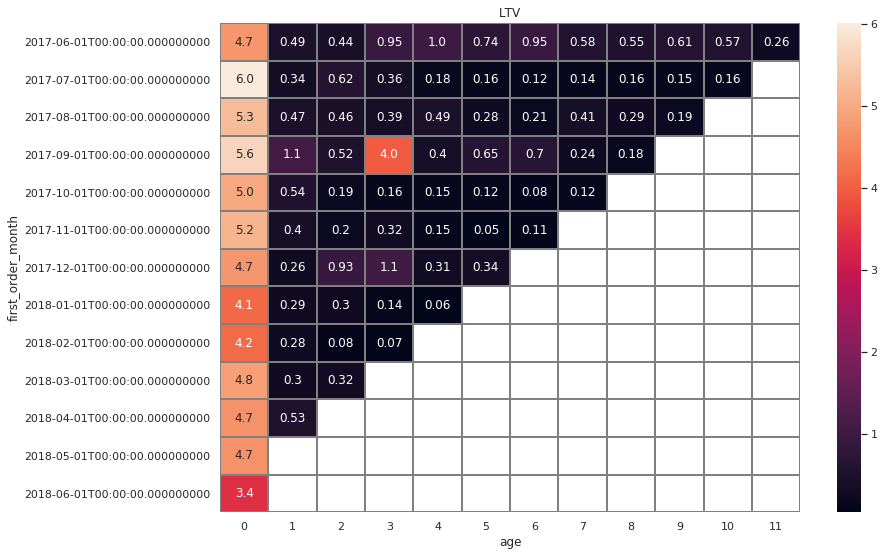

In [79]:
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(output, annot=True, fmt='.2', linewidths=1, linecolor='gray'); 

Построим теперь график накопительного LTV каждой когорты

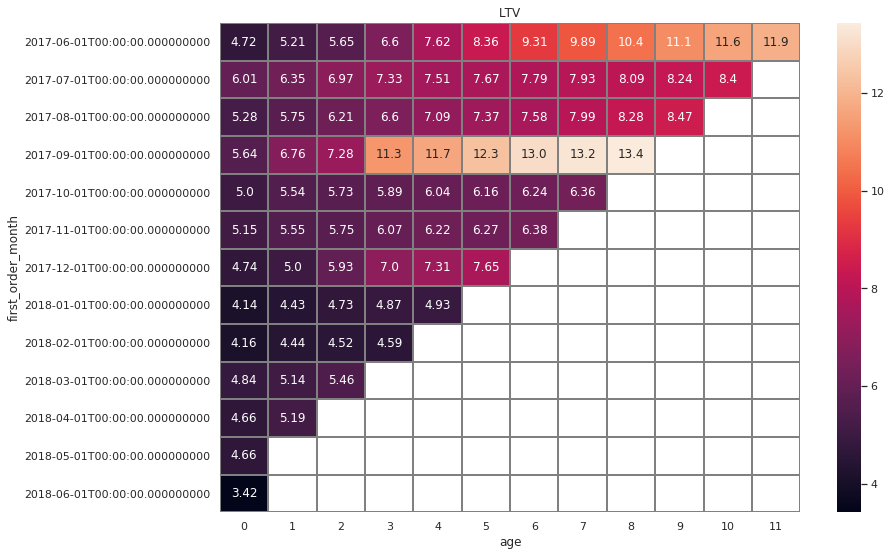

In [80]:
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(output.cumsum(axis=1).round(2) , annot=True, fmt='.3', linewidths=1, linecolor='gray'); 

In [86]:
output.cumsum(axis=1)[6].mean()

8.385

In [81]:
ltv_mean = output = report.pivot_table(
    index='first_order_month', values='ltv', aggfunc='mean'
).round(2) 
ltv_mean

,ltv
first_order_month,
2017-06-01,0.99
2017-07-01,0.76
2017-08-01,0.85
2017-09-01,1.49
2017-10-01,0.80
2017-11-01,0.91
2017-12-01,1.27
2018-01-01,0.99
2018-02-01,1.15


В расчёт включим когорты, «прожившие» не менее 6 месяцев

In [82]:
orders_6month = report[(
    report['age'] >= 6)]
orders_6month.head(5)

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
6,2017-06-01,2023,2017-12-01,1922.74,1922.74,6,0.950440
7,2017-06-01,2023,2018-01-01,1176.56,1176.56,7,0.581592
8,2017-06-01,2023,2018-02-01,1119.15,1119.15,8,0.553213
9,2017-06-01,2023,2018-03-01,1225.51,1225.51,9,0.605788
10,2017-06-01,2023,2018-04-01,1155.66,1155.66,10,0.571261


In [83]:
ltv_mean = orders_6month.pivot_table(index='first_order_month', values='ltv', aggfunc='mean').round(2).reset_index()
ltv_mean

,first_order_month,ltv
0,2017-06-01,0.59
1,2017-07-01,0.15
2,2017-08-01,0.27
3,2017-09-01,0.38
4,2017-10-01,0.10
5,2017-11-01,0.11


In [84]:
#output.cumsum(axis=1)[5].mean() 
#output.cumsum(axis=1)['5'].mean()

##### Вывод:  
Получается, что когорта 09-2017 принесла самую большую прибыль. Но это всё из-за аномального значения за 3 месяц. Желательно изучить эту аномалию. Если исключить эту когорту, то большую прибыль принесла 1 всё-таки когорта. Поздние когорты приносят меньше прибыли уже. Ну и выделяется "оживление" у когорт 12-2017 и 03-2018. Снова свяжем эти оживления с праздниками.

### Маркетинговые метрики

#### Рассчет общей суммы расходов на маркетинг. Выясним, как траты распределены по источникам. Визуализация изменения метрик во времени.

In [86]:
print('Общая сумма расходов на маркетинг', costs['costs'].sum())

Общая сумма расходов на маркетинг 329131.62


In [87]:
# сгруппируем по источникам затраты
costs_source = costs.groupby('source_id')['costs'].sum().reset_index()
print('Распределение затрат по источникам:')
costs_source

Распределение затрат по источникам:


,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [88]:
# Добавим столбец в процентном соотношении
costs_source['costs_part']=round((costs_source['costs']/costs['costs'].sum()*100),2)
costs_source

,source_id,costs,costs_part
0,1,20833.27,6.33
1,2,42806.04,13.01
2,3,141321.63,42.94
3,4,61073.60,18.56
4,5,51757.10,15.73
5,9,5517.49,1.68
6,10,5822.49,1.77


In [89]:
# сделаем свобную. Мне так проще строить график потому что
costs_source_pivot = costs_source.pivot_table(
    index=['source_id'],
    values='costs_part')
costs_source_pivot

,costs_part
source_id,
1,6.33
2,13.01
3,42.94
4,18.56
5,15.73
9,1.68
10,1.77


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f41e4da3b50>],
      dtype=object)

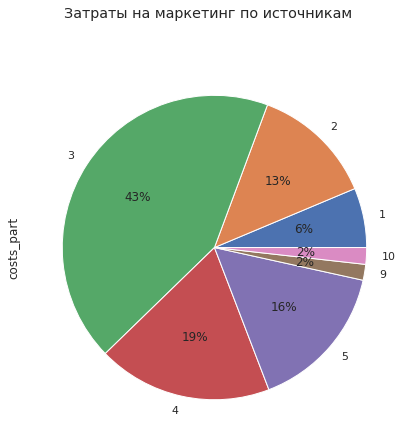

In [90]:
costs_source_pivot.plot(figsize = (7,7), legend=False, title='Затраты на маркетинг по источникам',
            kind='pie', autopct='%1.0f%%', subplots=True)
                


In [91]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [92]:
# посчитаем помесячный расход
costs_month = costs.groupby('month')['costs'].sum()
# costs_month = costs.groupby(['month','source_id']).agg({'costs': 'sum'})  пыталась source_id сохранить- не помогло
costs_month

month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

In [93]:
costs_month_1= costs.groupby('source_id')['costs'].sum()
costs_month_1

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

In [94]:
costs_month_for_plot=costs.groupby('month').sum().reset_index()
costs_month_for_plot['month'] = costs_month_for_plot['month'].astype('str')

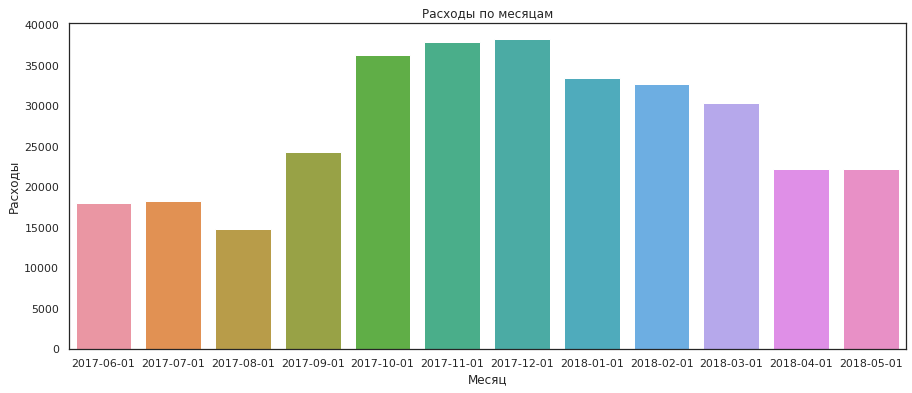

In [95]:
#costs_by_month_pivot.plot(kind = 'bar', title = 'Раcходы по месяцам')
plt.figure(figsize = (15,6))
sns.barplot(x = "month", y = "costs", data = costs_month_for_plot)
plt.title('Раcходы по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.show()

#Посмотрим, как затраты были распределны по месяцам
costs_report_pivot = costs.pivot_table(
    index= 'month',
    columns = 'source_id', 
    values='costs')

In [96]:
costs_pivot=costs.pivot_table(index = 'month', columns = 'source_id', values = 'costs', aggfunc = 'mean')


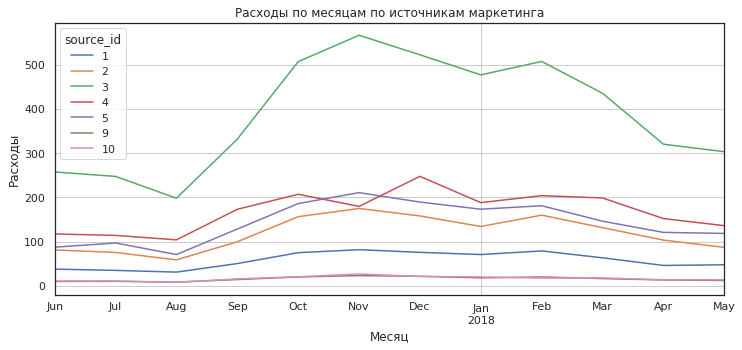

In [97]:
costs_pivot.plot(figsize=(12, 5), grid=True)
plt.title('Раcходы по месяцам по источникам маркетинга')
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.show()

##### Вывод:
Самые затратные источники : 3,4,5,2.  
Затрат не было на источники: 6,7,8.  

Самые большие затраты были в октябре, ноябре, декабре. Меньше всего затрат было летом.

#### Рассчет среднего CAC на одного покупателя для всего проекта и для каждого источника трафика. Отражение изменений метрик на графиках.

CAC (от англ. customer acquisition cost) — стоимость привлечения клиента. Сумма денег, во сколько обходится новый клиент компании.
Найдем затраты и выручку по каналам.

In [98]:
# добавляем помесячные расходы в когортный отчет
report_new = pd.merge(
    report, costs_month, left_on='first_order_month', right_on='month'
)
report_new

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv,costs
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,18015.00
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329,18015.00
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637,18015.00
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671,18015.00
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531,18015.00
...,...,...,...,...,...,...,...,...
73,2018-03-01,3533,2018-04-01,1063.05,1063.05,1,0.300892,30415.27
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2,0.315559,30415.27
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0,4.657597,22289.38
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1,0.531599,22289.38


In [99]:
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new['cac'].head()

0    8.905091
1    8.905091
2    8.905091
3    8.905091
4    8.905091
Name: cac, dtype: float64

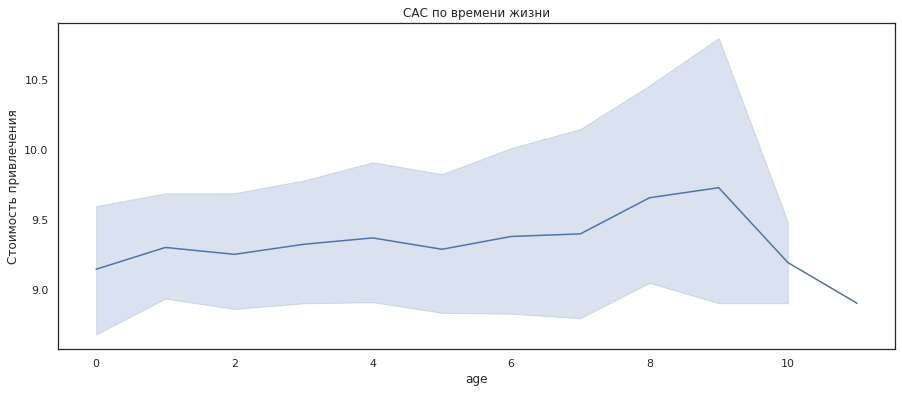

In [100]:
plt.figure(figsize = (15, 6))
ax = sns.lineplot(x = "age", y = "cac", data = report_new)
plt.title('CAC по времени жизни')
ax.set_xlabel('age')
ax.set_ylabel('Стоимость привлечения')
plt.show()

In [101]:
#сообразим как вывести по источнику расходы (сгруппируем по источнику затраты)
costs_per_source=costs.groupby('source_id')['costs'].sum().reset_index()
costs_per_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [102]:
# возьмем из таблицы visits только где дата начала сессии равна самому первому действию
visits_by_source = visits.query('start_ts == first_start_ts')
visits_by_source.head()

,device,end_ts,source_id,start_ts,uid,start_year,start_month,start_week,start_date,session_duration,first_start_ts,first_start_month,start_ts_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,18.0,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,28.0,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,28.0,2018-03-09 20:05:00,2018-03-01,2018-03-01,0
5,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0.0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0


In [103]:
# соединим полученную таблицу с orders, сгруппируем по источнику и выведем уник. пользователей, переименуем столбец 
customers_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'uid':'nunique'})\
                        .rename(columns={'uid':'customers'})
customers_by_source

,customers
source_id,
1,2899
2,3506
3,10473
4,10296
5,6931
7,1
9,1088
10,1329


In [104]:
# сделаем в одну строчку (норм таблицу), так проще соединять потом
customers_by_source = customers_by_source.reset_index().rename(columns = {'source id': 'source_id'}) 
customers_by_source

,source_id,customers
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [105]:
# соединим с costs
cac = customers_by_source.merge(costs_per_source).reset_index()
cac

,index,source_id,customers,costs
0,0,1,2899,20833.27
1,1,2,3506,42806.04
2,2,3,10473,141321.63
3,3,4,10296,61073.60
4,4,5,6931,51757.10
5,5,9,1088,5517.49
6,6,10,1329,5822.49


In [106]:
cac_itog = cac.merge(visits_by_source).reset_index()
cac

,index,source_id,customers,costs
0,0,1,2899,20833.27
1,1,2,3506,42806.04
2,2,3,10473,141321.63
3,3,4,10296,61073.60
4,4,5,6931,51757.10
5,5,9,1088,5517.49
6,6,10,1329,5822.49


In [107]:
# найдем, наконец-то, САС
cac['cac'] = cac['costs'] / cac['customers']
cac.sort_values('cac', ascending = False)

,index,source_id,customers,costs,cac
2,2,3,10473,141321.63,13.493901
1,1,2,3506,42806.04,12.209367
4,4,5,6931,51757.10,7.467479
0,0,1,2899,20833.27,7.186364
3,3,4,10296,61073.60,5.931779
5,5,9,1088,5517.49,5.071222
6,6,10,1329,5822.49,4.381106


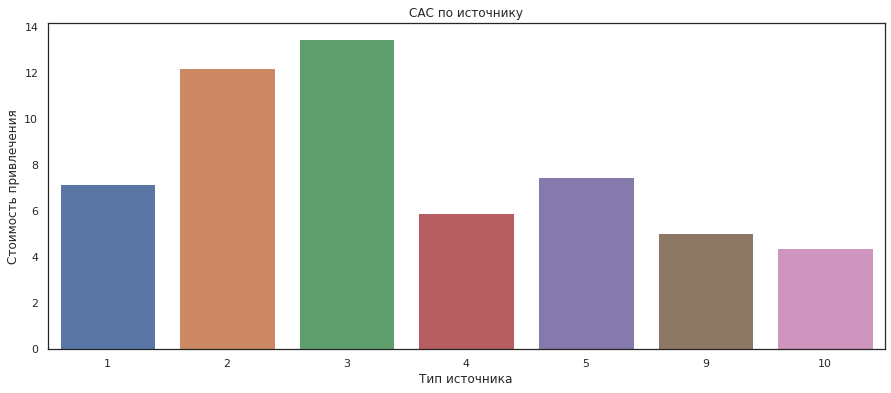

In [108]:
plt.figure(figsize = (15, 6))
ax = sns.barplot(x = "source_id", y = "cac", data = cac)
plt.title('CAC по источнику')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Стоимость привлечения')
plt.show()

##### Вывод:  
Самые дорогие источники привлечения клиента №3 и 2 , самые дешевые 9,10. Ну и 6,7,8 вообще без стоимости.

#### Рассчет ROMI по когортам в разрезе источников. Сравнение окупаемости за одинаковые периоды жизни когорт. Обратить внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV. Графики, отражающие изменения метрик во времени.

Маркетологи хотят знать, когда их вложения окупятся. Для них главная метрика — ROI (от англ. return on investments, «возврат на инвестиции»). Но тут вопрос про окупаемость маркетинга. Чтобы не путать окупаемость бизнеса с окупаемостью маркетинга, вместо ROI рассчитывают ROMI (от англ. return on marketing investments, «возврат на маркетинговые инвестиции»).

In [109]:
report_new

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,18015.00,8.905091
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329,18015.00,8.905091
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637,18015.00,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671,18015.00,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531,18015.00,8.905091
...,...,...,...,...,...,...,...,...,...
73,2018-03-01,3533,2018-04-01,1063.05,1063.05,1,0.300892,30415.27,8.608907
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2,0.315559,30415.27,8.608907
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0,4.657597,22289.38,9.793225
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1,0.531599,22289.38,9.793225


In [110]:
# посчитаем ROMI
report_new['romi'] = report_new['ltv'] / report_new['cac'] 
report_new['romi'].head()

0    0.530530
1    0.054500
2    0.049145
3    0.107205
4    0.114825
Name: romi, dtype: float64

In [111]:
# постройте новую сводную таблицу
result = report_new.pivot_table(
    index='first_order_month', columns='age', values='romi', aggfunc='mean'
)
 
result.cumsum(axis=1).round(2).fillna('')# выведите сводную таблицу на экран, предварительно посчитав накопительнй ROMI)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


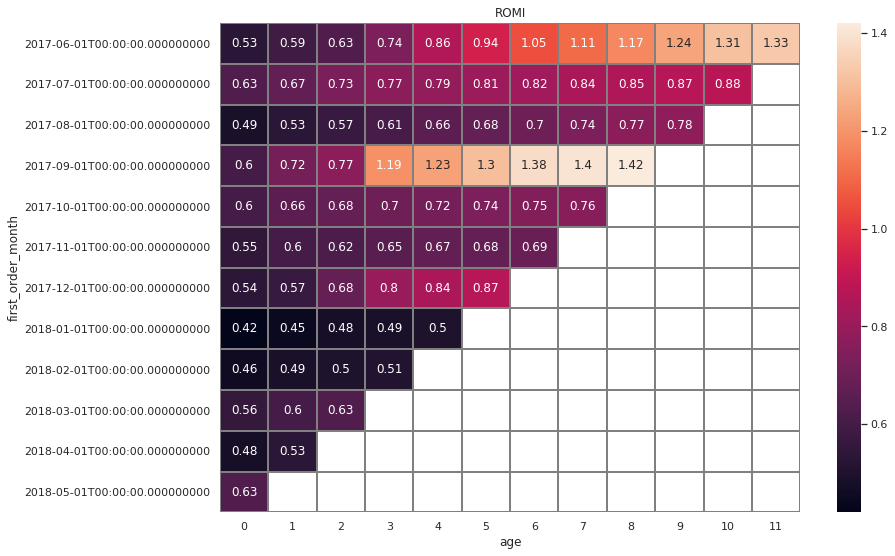

In [112]:
plt.figure(figsize=(13, 9))
plt.title('ROMI')
sns.heatmap(result.cumsum(axis=1).round(2) , annot=True, fmt='.3', linewidths=1, linecolor='gray')

Итак, теперь нам нужно посчитать ROMI источников каждой когорты в зависимости от времени жизни. У нас в таблице report нет информации по источникам, поэтому нужно собрать новую таблицу.  
Для этого нам нужны сведения по источникам: из '***customers_by_source***' возьмем '***customers***', из '***costs_source***' - '***costs***'   
из этого можно посчитать CAC, для ROMI нужен LTV, который высчитывается из таблицы orders, в которой нет столбца start_ts, но есть в таблице visits. Значит будем колдовать с orders и visits.



In [113]:
# проверка: customers, вы точно тут? 
customers_by_source

,source_id,customers
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [114]:
# проверка
costs_source

,source_id,costs,costs_part
0,1,20833.27,6.33
1,2,42806.04,13.01
2,3,141321.63,42.94
3,4,61073.60,18.56
4,5,51757.10,15.73
5,9,5517.49,1.68
6,10,5822.49,1.77


In [115]:
# соединим по source_id  и пока забудем про эту таблицу
costs_plus_custom= costs_source.merge(customers_by_source, on='source_id')
costs_plus_custom

,source_id,costs,costs_part,customers
0,1,20833.27,6.33,2899
1,2,42806.04,13.01,3506
2,3,141321.63,42.94,10473
3,4,61073.60,18.56,10296
4,5,51757.10,15.73,6931
5,9,5517.49,1.68,1088
6,10,5822.49,1.77,1329


In [116]:
# приведем таблицу visits к первоначальному виду и возьмем то, что нам надо
visits_form= visits[['device', 'start_ts', 'source_id','uid' ]]
visits_form

,device,start_ts,source_id,uid
0,touch,2017-12-20 17:20:00,4,16879256277535980062
1,desktop,2018-02-19 16:53:00,2,104060357244891740
2,touch,2017-07-01 01:54:00,5,7459035603376831527
3,desktop,2018-05-20 10:59:00,9,16174680259334210214
4,desktop,2018-03-09 20:05:00,4,16174680259334210214
...,...,...,...,...
359395,desktop,2018-04-23 21:11:00,10,12734910664455613822
359396,desktop,2017-11-08 13:39:00,4,6761309174945977743
359397,desktop,2017-07-31 12:13:00,3,11102751930812818282
359398,desktop,2018-03-20 15:11:00,4,272012551460639309


In [117]:
# Вычисляем первый источник для юзера  
# Прежде всего надо отсортировать все строки по полю “start_ts” по возрастанию
first_sourse=visits_form.sort_values('start_ts').groupby('uid').agg({'source_id':'first'})
first_sourse.head()

,source_id
uid,
11863502262781,3
49537067089222,2
297729379853735,3
313578113262317,2
325320750514679,5


In [118]:
# соединяем с orders
visits_orders_source=first_sourse.merge(orders, on='uid')
visits_orders_source.head()

,uid,source_id,buy_ts,revenue,buy_month,order_month
0,313578113262317,2,2018-01-03 21:51:00,0.55,2018-01-01,2018-01-01
1,1575281904278712,10,2017-06-03 10:13:00,1.22,2017-06-01,2017-06-01
2,1575281904278712,10,2017-06-03 17:39:00,1.83,2017-06-01,2017-06-01
3,2429014661409475,3,2017-10-11 18:33:00,73.33,2017-10-01,2017-10-01
4,2464366381792757,5,2018-01-28 15:54:00,2.44,2018-01-01,2018-01-01


In [119]:
# для каждого клиента получим дату его первого заказа
first_orders = visits_orders_source.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [120]:
# добавляем первые месяца в таблицу
visits_orders_new = pd.merge(visits_orders_source,first_orders, on='uid')
visits_orders_new.head()

,uid,source_id,buy_ts,revenue,buy_month,order_month,first_order_month
0,313578113262317,2,2018-01-03 21:51:00,0.55,2018-01-01,2018-01-01,2018-01-01
1,1575281904278712,10,2017-06-03 10:13:00,1.22,2017-06-01,2017-06-01,2017-06-01
2,1575281904278712,10,2017-06-03 17:39:00,1.83,2017-06-01,2017-06-01,2017-06-01
3,2429014661409475,3,2017-10-11 18:33:00,73.33,2017-10-01,2017-10-01,2017-10-01
4,2464366381792757,5,2018-01-28 15:54:00,2.44,2018-01-01,2018-01-01,2018-01-01


In [121]:
# Группируем  по месяцу первой покупки + источнику, находим кол-во людей в когортах
cohort_sizes = (
    visits_orders_new.groupby(['first_order_month','source_id'])
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'source_id', 'n_buyers']
cohort_sizes.head()

,first_order_month,source_id,n_buyers
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384


In [122]:
# Группируем табличку по  источнику, месяцу первой покупки, текущему месяцу, суммируем revenue
cohorts = (
    visits_orders_new.groupby(['source_id','first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
cohorts.head()

,source_id,first_order_month,order_month,revenue
0,1,2017-06-01,2017-06-01,1378.70
1,1,2017-06-01,2017-07-01,414.98
2,1,2017-06-01,2017-08-01,419.43
3,1,2017-06-01,2017-09-01,714.24
4,1,2017-06-01,2017-10-01,811.20


In [123]:
# Объединяем по месяцу первой покупки и источнику таблички
report = pd.merge(cohort_sizes, cohorts, on=['first_order_month','source_id'])
report.head()

,first_order_month,source_id,n_buyers,order_month,revenue
0,2017-06-01,1,190,2017-06-01,1378.70
1,2017-06-01,1,190,2017-07-01,414.98
2,2017-06-01,1,190,2017-08-01,419.43
3,2017-06-01,1,190,2017-09-01,714.24
4,2017-06-01,1,190,2017-10-01,811.20


In [124]:
# считаем всё как в первый раз
margin_rate = 1 # по условию

report['gp'] = report['revenue'] * margin_rate
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_order_month,source_id,n_buyers,order_month,revenue,gp,age
0,2017-06-01,1,190,2017-06-01,1378.70,1378.70,0
1,2017-06-01,1,190,2017-07-01,414.98,414.98,1
2,2017-06-01,1,190,2017-08-01,419.43,419.43,2
3,2017-06-01,1,190,2017-09-01,714.24,714.24,3
4,2017-06-01,1,190,2017-10-01,811.20,811.20,4


In [125]:
# а вот и недостающий ltv:
report['ltv'] = report['gp'] / report['n_buyers']
report.head()

,first_order_month,source_id,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,1,190,2017-06-01,1378.70,1378.70,0,7.256316
1,2017-06-01,1,190,2017-07-01,414.98,414.98,1,2.184105
2,2017-06-01,1,190,2017-08-01,419.43,419.43,2,2.207526
3,2017-06-01,1,190,2017-09-01,714.24,714.24,3,3.759158
4,2017-06-01,1,190,2017-10-01,811.20,811.20,4,4.269474


In [126]:
# группируем как надо, готовим таблицу к воссоединению с "истиной"
ltv_source_group= report.groupby(['source_id','first_order_month','age']).agg({'ltv': 'sum'}).reset_index()
ltv_source_group

,source_id,first_order_month,age,ltv
0,1,2017-06-01,0,7.256316
1,1,2017-06-01,1,2.184105
2,1,2017-06-01,2,2.207526
3,1,2017-06-01,3,3.759158
4,1,2017-06-01,4,4.269474
...,...,...,...,...
511,10,2018-03-01,0,3.432473
512,10,2018-03-01,1,0.068333
513,10,2018-03-01,2,0.033817
514,10,2018-04-01,0,2.447944


In [127]:
# всё соединяем для расчета romi
all_for_romi = pd.merge(costs_plus_custom, ltv_source_group, on='source_id')
all_for_romi 

,source_id,costs,costs_part,customers,first_order_month,age,ltv
0,1,20833.27,6.33,2899,2017-06-01,0,7.256316
1,1,20833.27,6.33,2899,2017-06-01,1,2.184105
2,1,20833.27,6.33,2899,2017-06-01,2,2.207526
3,1,20833.27,6.33,2899,2017-06-01,3,3.759158
4,1,20833.27,6.33,2899,2017-06-01,4,4.269474
...,...,...,...,...,...,...,...
510,10,5822.49,1.77,1329,2018-03-01,0,3.432473
511,10,5822.49,1.77,1329,2018-03-01,1,0.068333
512,10,5822.49,1.77,1329,2018-03-01,2,0.033817
513,10,5822.49,1.77,1329,2018-04-01,0,2.447944


In [128]:
all_for_romi['cac'] = all_for_romi['costs'] / all_for_romi['customers']

In [129]:
all_for_romi['romi'] = all_for_romi['ltv'] / all_for_romi['cac']

In [130]:
all_for_romi

,source_id,costs,costs_part,customers,first_order_month,age,ltv,cac,romi
0,1,20833.27,6.33,2899,2017-06-01,0,7.256316,7.186364,1.009734
1,1,20833.27,6.33,2899,2017-06-01,1,2.184105,7.186364,0.303924
2,1,20833.27,6.33,2899,2017-06-01,2,2.207526,7.186364,0.307183
3,1,20833.27,6.33,2899,2017-06-01,3,3.759158,7.186364,0.523096
4,1,20833.27,6.33,2899,2017-06-01,4,4.269474,7.186364,0.594108
...,...,...,...,...,...,...,...,...,...
510,10,5822.49,1.77,1329,2018-03-01,0,3.432473,4.381106,0.783472
511,10,5822.49,1.77,1329,2018-03-01,1,0.068333,4.381106,0.015597
512,10,5822.49,1.77,1329,2018-03-01,2,0.033817,4.381106,0.007719
513,10,5822.49,1.77,1329,2018-04-01,0,2.447944,4.381106,0.558750


In [131]:
# создадим словарь источников
source_dict = {'1':'источник 1', '2':'источник 2', '3':'источник 3', '4':'источник 4',
               '5':'источник 5', '9':'источник 9', '10':'источник 10'}

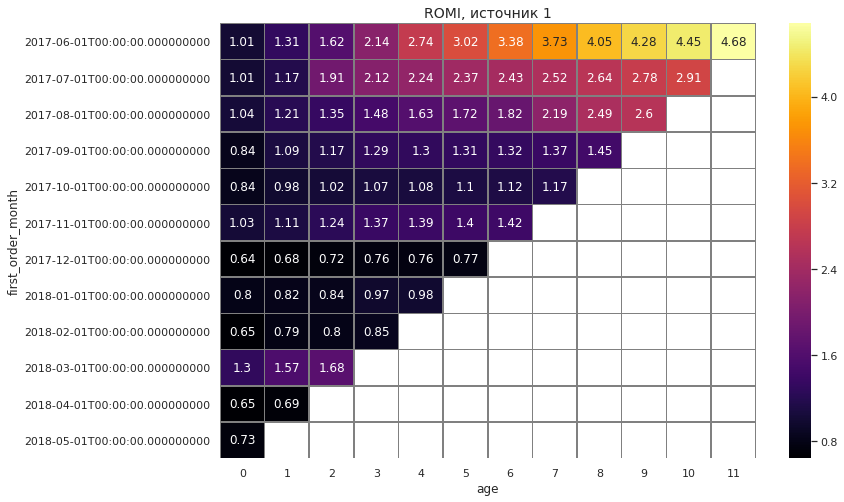

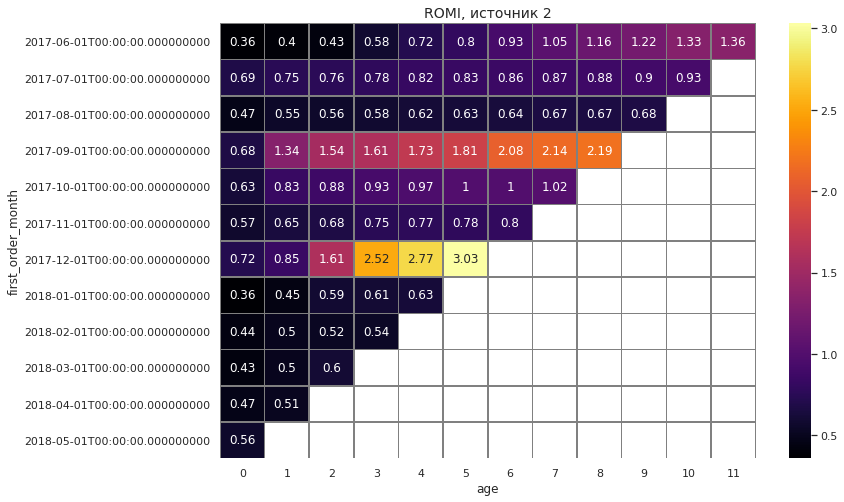

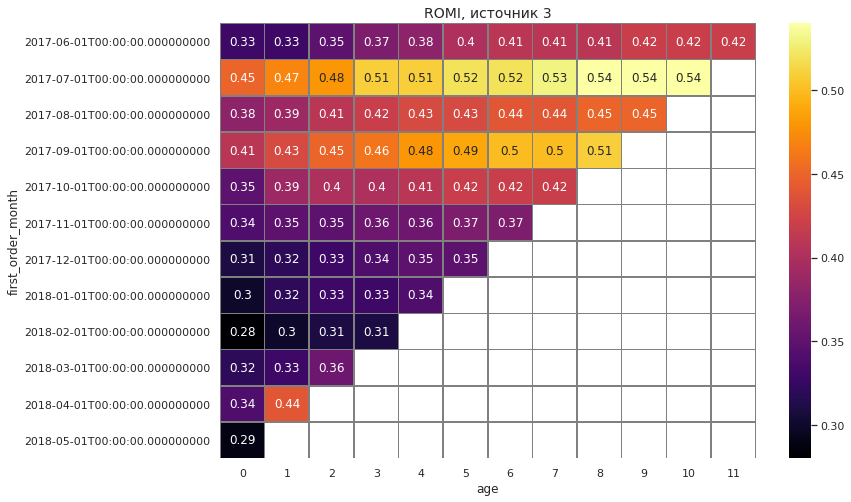

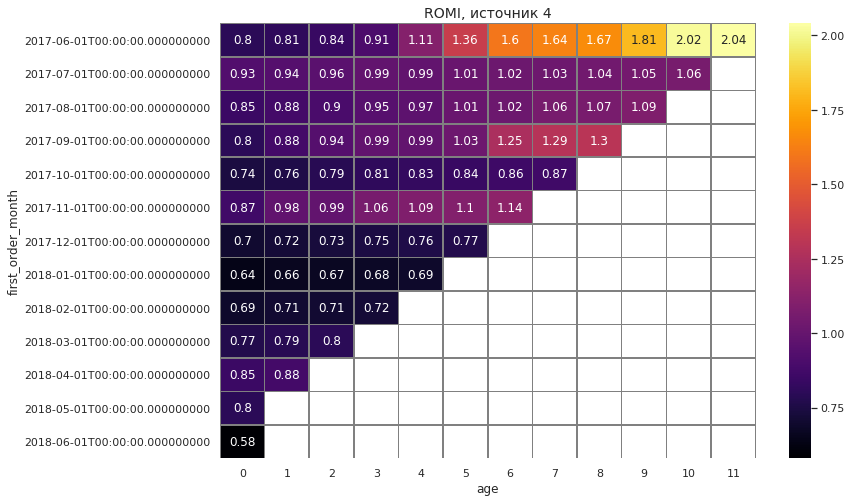

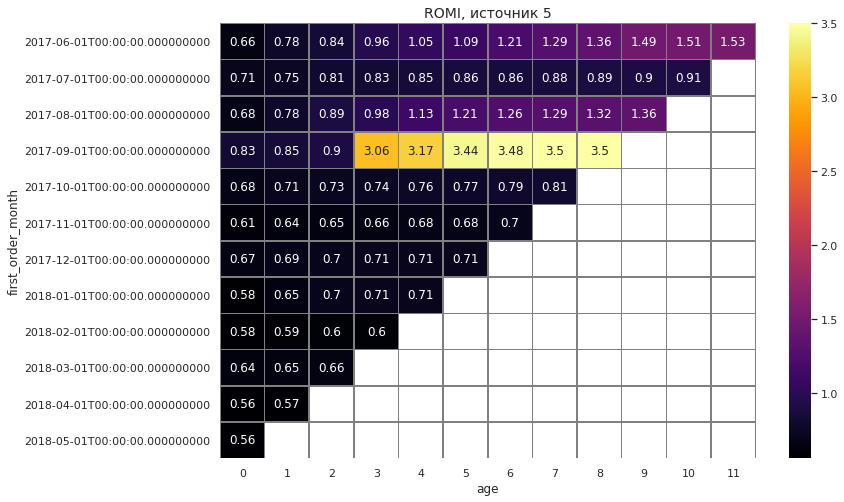

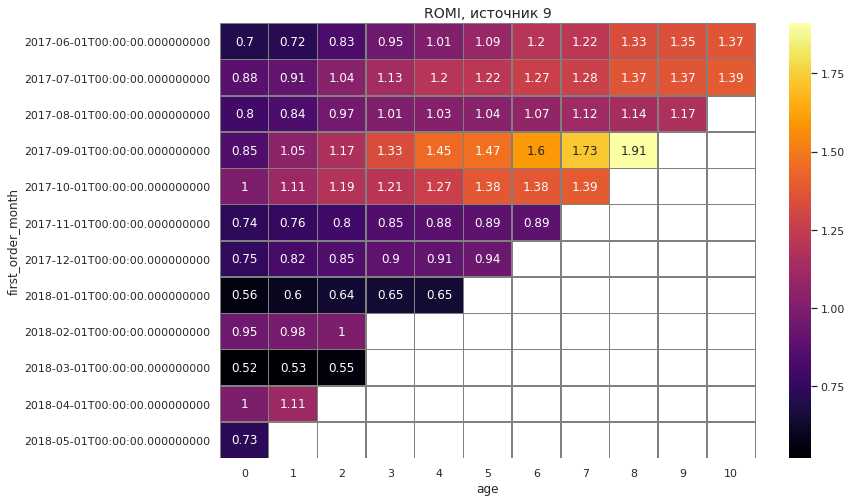

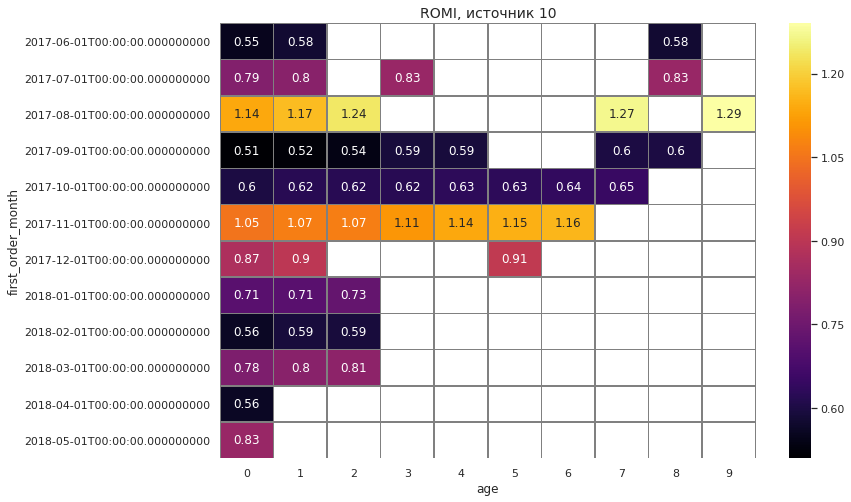

In [132]:
# прогоним значения словаря по циклу и построим график каждому источнику
for source in source_dict:
    romi_pivot = (all_for_romi.query('source_id == @source')
                    .pivot_table(index='first_order_month', 
                                 columns='age', 
                                 values='romi', 
                                 aggfunc='mean').cumsum(axis=1).round(2)
                   )
    sns.set(style='white')
    plt.figure(figsize=(12, 8))
    sns.heatmap(romi_pivot, annot=True, fmt='.3g', 
                linewidths=0.5, linecolor='gray', cmap='inferno')
    plt.title('ROMI, {}'.format(source_dict[source]), fontsize=14)
    plt.show()

#####  Вывод:   
Окупаемость- ROMI по источникам:

1 источник: окупаемость самая эффективная до когорты 2017-11, затем снизилась.  
2 источник: 2017-06 - окупилась за 8 месяцев, 2017-09 - во 2-м, 2017-10 - в 6-ом, 2017-12 в 3ем, остальные еще не окупились.  
3 источник вообще не окупился за весь период.  
4 источник: 2017-06 окупилась в 5 месяце, 2017-07,08,09- в 6-ом, 2017-11 - в 4-ом месяце.  
5 источник: 2017-06,08 - 5 месяц, 2017-09 - вообще окупилась в 3 раза за 4 месяца.  
9 источник: окупились первые 5 когорт за разные месяцы.  
10 источник: окупились 2017-08 и 2017-11 за первый же месяц.

## Вывод:

***Продуктовые метрики:***

В среднем, в день заходят на сервис около 900 пользователей. Это зависит от сезона. Летом меньше посещают сайт.  Кол-во посещений пользователей на сайт тоже зависит от сезона  и от «праздников» и диапазон очень широк тут от 400 до 1700 посетителей, особенно много посещений в предпраздничные дни. Время пребывания на сайте, самое частое значение, – 1 минута. Коэффициент удержания падает с каждым месяцем, то есть теряем покупателей.

***Метрики электронной коммерции:***

Большинство покупок было совершено меньше, чем за день с момента первого посещения.
Cреднее количество покупок на одного покупателя когорт проживших больше 6 месяцев = 1,4 покупки.  Средний чек покупателя примерно 5 тыс. 

***Маркетинговые метрики:***

Самые затратные источники : 3,4,5,2. Затрат не было на источники: 6,7,8.
Самые большие затраты были в октябре, ноябре, декабре. Меньше всего затрат было летом.
Самые дорогие источники привлечения клиента №3 и 2 , самые дешевые 9,10. Ну и 6,7,8 вообще без стоимости.
Быстрее всех окупился исчтоник №1. 

Больше всего покупателей было в когортах 10,11, 12 - 2017. Самый большое ср.кол-во покупок у когорты 06-2017, эта же когорта окупилась за 7 месяцев. Еще выявлена окупаемость когорты 09-2017 за 4 месяца: в 4-м месяце наблюдается аномалия, которую необходимо изучить. Остальные когорты не окупились в общем итоге.

***Рекомендации:***
Маркетологам стоит делать упор на источник №1: окупаемость быстрая, малозатратный. Увеличить бюджет на источник 10. 
Не выделять бюджет на 3 источник, который не окупился за весь период. Необходимо провести дополнительные исследования для разрешения вопроса о положительном ROMI в отношений источников 4 и 5: пользователи пользуются, а окупаемость отрицательная. 

По всем графикам видно, что на кол-во продаж и средний чек влияет сезонность и праздники. Поэтому необходимо это учитывать и в "горячие" периоды увеличить рекламные компании. В летний период уменьшить бюджет на рекламу.  
Разработать стратегию по удержанию клиентов.  


